## TensorFlow Eager Execution

TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later. This makes it easy to get started with TensorFlow and debug models, and it reduces boilerplate as well. 

In [1]:
from __future__ import absolute_import, division, print_function
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
print("TensorFlow version: {}".format(tf.VERSION))

C:\Users\WEIL\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.8.0


In [21]:
import tensorflow.contrib.eager as tfe

In [12]:
import numpy as np
import pandas as pd

In [9]:
from sklearn import datasets

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# this section cannot be run in eager mode
zero = tf.Variable(0)
one = tf.constant(1)
new_value = tf.add(zero, one)
update = tf.assign(zero, new_value)

# init_op = tf.initialize_all_variables()
init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)
for _ in range(5):
    sess.run(update)
    print(sess.run(zero))

sess.close()

In [2]:
# eager mode
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [13]:
# import Iris data
iris = datasets.load_iris()

X = pd.DataFrame(iris.data, columns=[ 'Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
print(X.shape)
Y = pd.DataFrame(iris.target, columns=['target'])
print(Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# categorical values with known levels
# gender = tf.feature_column.categorical_column_with_vocabulary_list('gender', ['Female', 'Male'])
# categorical values with unkown levels (many levels)
# gender = tf.feature_column.categorical_column_with_hash_bucket('gender', hash_bucket_size=1000)

# continuous numeric values
Sepal_Length = tf.feature_column.numeric_column('Sepal_Length')
Sepal_Width = tf.feature_column.numeric_column('Sepal_Width')
Petal_Length = tf.feature_column.numeric_column('Petal_Length')
Petal_Width = tf.feature_column.numeric_column('Petal_Width')

feat_cols = [Sepal_Length, Sepal_Width, Petal_Length, Petal_Width]

input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_train, y=y_train, batch_size=30, num_epochs=None, shuffle=True)

(150, 4)
(150, 1)


In [24]:
# another way to import the Iris data
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

Local copy of the dataset file: C:\Users\WEIL\.keras\datasets\iris_training.csv
example features: tf.Tensor([5.4 3.7 1.5 0.2], shape=(4,), dtype=float32)
example label: tf.Tensor(0, shape=(), dtype=int32)


## Build Model

Here we use a dense, or fully-connected neural network: the neurons in one layer receive input connections from every neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:

![full_network](eager_execution/full_network.png "Full_network")


### Use tf.Keras API

Let's build two Dense layers with 10 nodes each, 
and an output layer with 3 nodes representing our label predictions. 
The first layer's input_shape parameter corresponds to 
the amount of features from the dataset, and is required.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)), # input_shape required
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

### Define the loss and gradient function

Here we will calculate its loss using the tf.losses.sparse_softmax_cross_entropy function 

In [28]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

### Create optimizer

TensorFlow has many optimization algorithms available for training. This model uses the tf.train.GradientDescentOptimizer that implements the stochastic gradient descent (SGD) algorithm

In [20]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

### Train the model

The following code block sets up these training steps:

- Iterate each epoch. An epoch is one pass through the dataset.
- Within an epoch, iterate over each example in the training Dataset grabbing its features (x) and label (y).
- Using the example's features, make a prediction and compare it with the label. - Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
- Use an optimizer to update the model's variables.
- Keep track of some stats for visualization.
- Repeat for each epoch.

In [29]:
# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.306, Accuracy: 35.000%
Epoch 050: Loss: 0.552, Accuracy: 76.667%
Epoch 100: Loss: 0.313, Accuracy: 95.000%
Epoch 150: Loss: 0.213, Accuracy: 97.500%
Epoch 200: Loss: 0.160, Accuracy: 96.667%


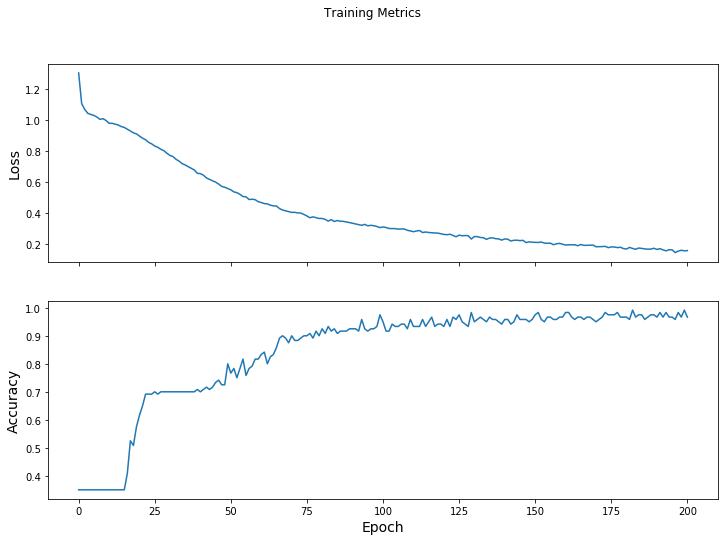

In [30]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

### Get the test dataset



In [31]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [32]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


### Make predictions on new data

In [33]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica
